In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-depression-dataset/student_depression_dataset.csv


## **Import Libraries** ##

In [2]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and predicting
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier , Pool
from sklearn.metrics import roc_auc_score

# Hyperparameter optimization
import optuna

In [3]:
data = pd.read_csv("/kaggle/input/student-depression-dataset/student_depression_dataset.csv")
data.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [4]:
data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,1.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [6]:
data.isnull().sum()

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

## **EDA + Preprocessing** ##

In [7]:
cat_cols = data.select_dtypes(include=['object']).columns
num_cols = data.select_dtypes(include=['int' , 'float']).columns.drop('id')

print("Categorical columns count : " , len(cat_cols))
print("Numerical columns count : " , len(num_cols))

Categorical columns count :  9
Numerical columns count :  8


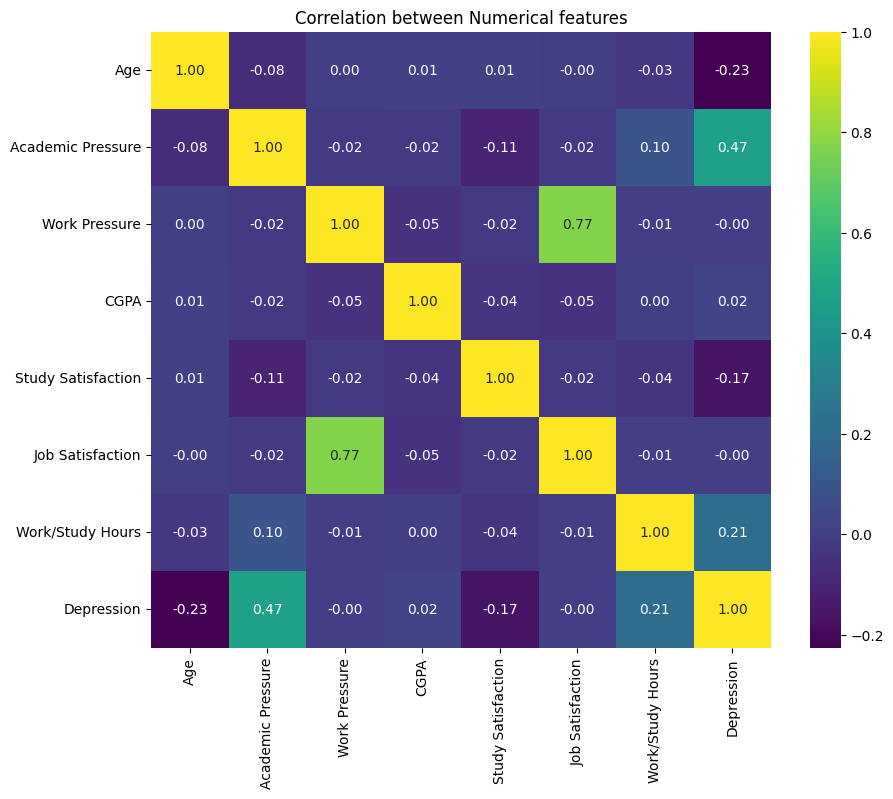

In [8]:
plt.figure(figsize=(10,8))
corr_matrix = data[num_cols].corr()

sns.heatmap(corr_matrix , annot = True, cmap='viridis' , fmt = ".2f")
plt.title("Correlation between Numerical features")
plt.show()

In [9]:
X = data.drop(['id' , 'Depression' , 'City'  , 'Profession'] , axis=1)
y = data['Depression']

In [10]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int' , 'float']).columns.tolist()

print("Categorical : " , cat_cols)
print("\nNumerical : " , num_cols)

Categorical :  ['Gender', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Financial Stress', 'Family History of Mental Illness']

Numerical :  ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']


## **Modeling** ##

In [11]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1 , log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0 , log=True),
        'random_state': 42,
        'eval_metric': 'AUC',
        'verbose': 0,
        'early_stopping_rounds': 50,
        #'task_type': 'GPU',       
        'devices': '0'
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train_pool = Pool(X_train, y_train, cat_features=cat_cols)
    test_pool = Pool(X_test, y_test, cat_features=cat_cols)
    catb = CatBoostClassifier(**params)
    catb.fit(train_pool, eval_set=test_pool)
    y_prob = catb.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_prob)

    return roc_auc

In [18]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, show_progress_bar=True)
best_params = study.best_trial.params
print("\nBest Hyperparameters from Optuna:")
print(best_params)

[I 2025-08-20 15:55:08,617] A new study created in memory with name: no-name-e1b7021c-6d1e-422e-8228-303fe6a016ff


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-08-20 15:55:15,315] Trial 0 finished with value: 0.915117956131797 and parameters: {'iterations': 817, 'learning_rate': 0.07496758059356194, 'depth': 6, 'l2_leaf_reg': 0.021671486596359393}. Best is trial 0 with value: 0.915117956131797.
[I 2025-08-20 15:55:27,167] Trial 1 finished with value: 0.9143854837336294 and parameters: {'iterations': 1201, 'learning_rate': 0.02495243230613293, 'depth': 8, 'l2_leaf_reg': 0.003649116554471796}. Best is trial 0 with value: 0.915117956131797.
[I 2025-08-20 15:55:46,522] Trial 2 finished with value: 0.9153098725996274 and parameters: {'iterations': 2146, 'learning_rate': 0.015482990768439078, 'depth': 5, 'l2_leaf_reg': 6.312062037223052}. Best is trial 2 with value: 0.9153098725996274.
[I 2025-08-20 15:55:56,529] Trial 3 finished with value: 0.9145922948174382 and parameters: {'iterations': 2320, 'learning_rate': 0.03611864815613398, 'depth': 8, 'l2_leaf_reg': 5.720960051093851}. Best is trial 2 with value: 0.9153098725996274.
[I 2025-08-20

In [19]:
iters = 2146
lr = 0.015482990768439078
d = 5
l2 = 6.312062037223052

In [20]:
catb = CatBoostClassifier(
    iterations = iters , 
    learning_rate=lr , 
    depth=d , 
    l2_leaf_reg=l2 ,
    early_stopping_rounds= 50,
    random_state=42 , 
    verbose=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols)

In [21]:
catb.fit(train_pool, eval_set=test_pool)
y_prob = catb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
    
print("ROC AUC Score : " , f"{roc_auc:.6f}")

ROC AUC Score :  0.915289


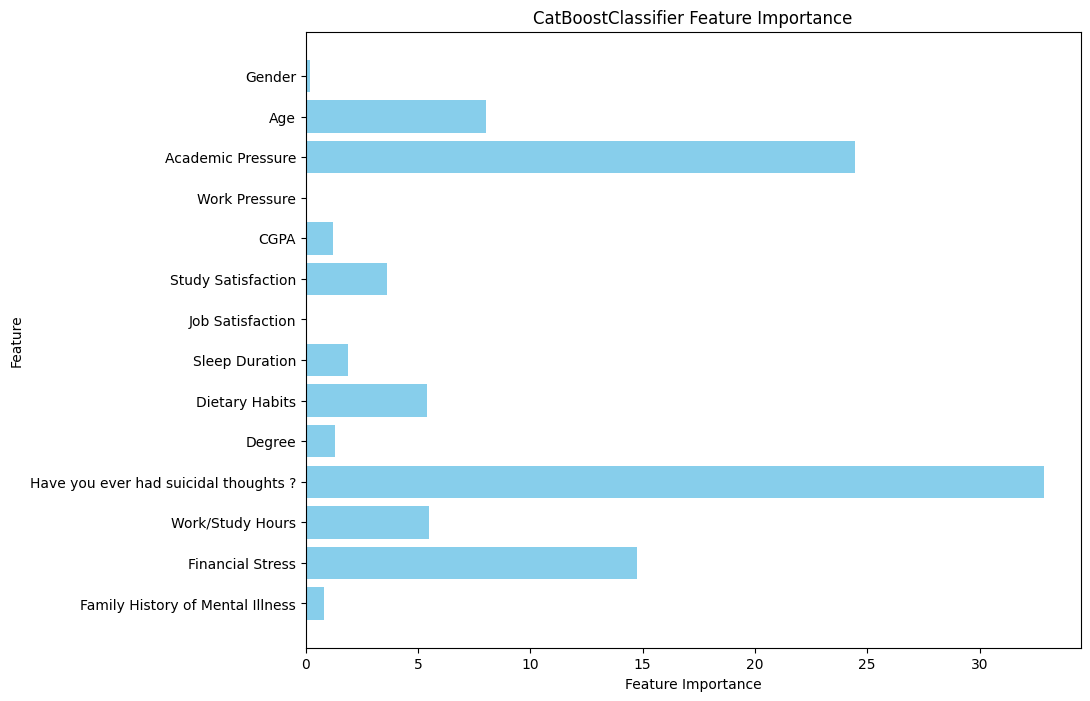

In [22]:
importance = catb.get_feature_importance()
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importance})

feature_importance = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoostClassifier Feature Importance')
plt.gca().invert_yaxis() # Invert y-axis to have the most important feature at the top
plt.show()